In [1]:
import numpy as np
import os
from tqdm import tnrange, tqdm_notebook
import matplotlib.pyplot as plt
import time
import scipy
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import sem, t



# Plot/Analyze L1 Weights

In [2]:
def unit_l1_norms(weights_file, save_dir):
    weights = np.load(weights_file)
    norm_array = np.empty((weights.shape[1], weights.shape[0]//50))
    for n in tnrange(weights.shape[0]//50):
        for x in range(weights.shape[1]):
            norm = np.sum(np.abs(weights[n*50:(n+1)*50, x]))
            norm_array[x,n] = norm
            
    unit_per_pixel = np.empty((weights.shape[1], weights.shape[0]//50))
    for x in tnrange(norm_array.shape[0]):
        best_units = np.flip(np.argsort(norm_array[x,:]))
        unit_per_pixel[x,:] = best_units
    
    sum_norms = np.empty((weights.shape[0]//50))
    for n in tnrange(weights.shape[0]//50):
        unit_norm = np.sum(norm_array[:,n])
        sum_norms[n] = unit_norm
    
    sorted_units = np.argsort(sum_norms)
    sorted_units = np.flip(sorted_units)
    
    print(unit_per_pixel.shape)
    print(sorted_units.shape)
  
    np.save(os.path.join(save_dir, "yass_l1_pixel_units.npy"), unit_per_pixel)
    np.save(os.path.join(save_dir, "yass_l1_sorted_units.npy"), sorted_units)    

In [3]:
weights_file = "/ssd/joon/2017_11_29_ns/yass/weights/yass_l1_weights.npy"
save_dir = "/ssd/joon/2017_11_29_ns/yass/"


unit_l1_norms(weights_file, save_dir)


(13870, 2094)
(2094,)


In [4]:
def plot_l1_weights(unit_weights, unit):

    temp_weights = np.mean(unit_weights, axis=1)
    max_time = np.argmax(temp_weights)
    min_time = np.argmin(temp_weights)
    on_weights = unit_weights[min(max_time,min_time), :]
    off_weights = unit_weights[max(max_time,min_time), :]
        
    fig, axs = plt.subplots(nrows=3, figsize = (5,7))
    on = axs[0].imshow(on_weights.reshape((95,146)))
    off = axs[1].imshow(off_weights.reshape((95,146)))
    axs[2].plot(temp_weights)
    
    axs[0].axis("off")
    axs[1].axis("off")
    
    axs[0].set_title("ON Spatial")
    axs[1].set_title("OFF Spatial")
    axs[2].set_title("Temporal")
    
    fig.suptitle("Unit "+str(unit)+" L1 Weights")
    
    plt.colorbar(on, ax=axs[0], shrink = 0.75)
    plt.colorbar(off, ax=axs[1], shrink = 0.75)
    
def multi_plot_l1_weights(weights_file, sorted_file, unit_no, save_dir):
    weights = np.load(weights_file)
    sorted_units = np.load(sorted_file)
    
    with PdfPages(os.path.join(save_dir, "yass_l1_weights.pdf")) as pdf:
        for i in tnrange(unit_no):
            unit = sorted_units[i]
            unit_weights = weights[unit*50 : (unit+1)*50, :]
            fig = plot_l1_weights(unit_weights, unit)
            pdf.savefig(fig)
            plt.close()    

In [5]:
weights_file = "/ssd/joon/2017_11_29_ns/yass/weights/yass_l1_weights.npy"
sorted_file = "/ssd/joon/2017_11_29_ns/yass/yass_l1_sorted_units.npy"
save_dir = "/ssd/joon/2017_11_29_ns/figures/"
unit_no = 2094

multi_plot_l1_weights(weights_file, sorted_file, unit_no, save_dir)

# Corr Values

In [8]:
lasso = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/yass_l1_smooth_decoded.npy")
ridge = np.load("/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy")
true = np.load("/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy")

In [13]:
lasso_corr = np.empty((true.shape[0]))

for i in tnrange(true.shape[0]):
    corr = np.corrcoef(lasso[:,i], true[:,i])[0][1]
    lasso_corr[i] = corr

confidence = 0.99

lasso_std_err = sem(lasso_corr) * t.ppf((1+confidence)/2, lasso_corr.shape[0]-1)
lasso_mean = np.mean(lasso_corr)

print(lasso_mean - lasso_std_err, lasso_mean + lasso_std_err)


0.9819614864908744 0.98298711560722


In [14]:
ridge_corr = np.empty((true.shape[0]))

for i in tnrange(true.shape[0]):
    corr = np.corrcoef(ridge[:,i], true[:,i])[0][1]
    ridge_corr[i] = corr
    
ridge_std_err = sem(ridge_corr) * t.ppf((1+confidence)/2, ridge_corr.shape[0]-1)
ridge_mean = np.mean(ridge_corr)

print(ridge_mean - ridge_std_err, ridge_mean + ridge_std_err)


0.9851923304826427 0.9861636331585901


Text(0.5, 1.0, 'Smooth Decoded Test Corr Comparison +/- 99% CI')

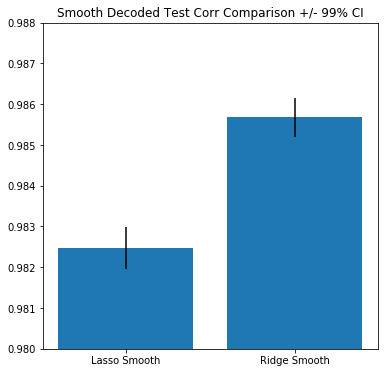

In [18]:
fig, axs = plt.subplots(figsize = (6,6))
    
bar_names = ["Lasso Smooth", "Ridge Smooth"]
    
plt.bar([0,1], [lasso_mean, ridge_mean], yerr=[lasso_std_err, ridge_std_err], tick_label = bar_names) 
plt.ylim(0.98,0.988)
plt.title("Smooth Decoded Test Corr Comparison +/- 99% CI")

# L1 vs L2 Decoding Plots

In [2]:
def indiv_compare_plots(true_img, lasso_img, ridge_img, index):
    fig, axs = plt.subplots(ncols=3, figsize = (11,5))
    
    lasso_corr = np.corrcoef(true_img, lasso_img)[0][1]
    ridge_corr = np.corrcoef(true_img, ridge_img)[0][1]
    
    axs[0].imshow(true_img.reshape((95,146)))
    axs[0].set_title("Img "+str(index)+": True")
    
    axs[1].imshow(ridge_img.reshape((95,146)))
    axs[1].set_title("Img "+str(index)+": Ridge (" +str(round(ridge_corr, 4))+")")
    
    axs[2].imshow(lasso_img.reshape((95,146)))
    axs[2].set_title("Img "+str(index)+": LASSO ("+str(round(lasso_corr, 4))+")")
    
    fig.tight_layout()

def multi_compare_plots(true_file, lasso_file, ridge_file, plot_no, save_dir):
    true_images = np.load(true_file)
    lasso_images = np.load(lasso_file)
    ridge_images = np.load(ridge_file)
    
    with PdfPages(os.path.join(save_dir, "lasso_ridge_smooth_comparison.pdf")) as pdf:
        for i in tnrange(0,plot_no):
            true_img = true_images[i,:]
            lasso_img = lasso_images[i,:]
            ridge_img = ridge_images[i,:]
            
            fig = indiv_compare_plots(true_img, lasso_img, ridge_img, i)
            pdf.savefig(fig)
            plt.close()


In [3]:
true_file = "/ssd/joon/2017_11_29_ns/images/smooth_test_images.npy"
lasso_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_l1_smooth_decoded.npy"
ridge_file = "/ssd/joon/2017_11_29_ns/yass/decoded/yass_smooth_test_decoded.npy"
plot_no = 100
save_dir = "/ssd/joon/2017_11_29_ns/figures/"




multi_compare_plots(true_file, lasso_file, ridge_file, plot_no, save_dir)

# Full Image Decoding Plots